<a href="https://colab.research.google.com/github/JackGraymer/Face-Recognition/blob/main/face_recognition_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition - Model Evaluation

## Introduction

Face recognition is a fundamental task in computer vision with applications ranging from personal device authentication to large-scale surveillance systems. In recent years, the field has witnessed significant advancements due to the development of deep learning architectures and the availability of large annotated datasets.

Big tech companies have been at the forefront of deploying high-performance face recognition systems:

* **Google** introduced *FaceNet*, which maps faces into a compact Euclidean space and achieves >99% accuracy on benchmarks like LFW (Labeled Faces in the Wild).
* **Facebook** developed *DeepFace*, one of the first deep learning face systems to surpass human-level accuracy.
* **Apple** and **Microsoft** use proprietary models optimized for real-time face verification and authentication in constrained environments (e.g., mobile devices).
* **Open-source models** like *VGGFace*, *ArcFace*, and *Dlib* continue to be widely used for research and production purposes.

Despite these advances, building and evaluating face recognition models remains a challenging task—especially when considering smaller, less curated datasets or when generalizing to new identities.

## Project Objective

This project aims to **evaluate and compare different deep learning models** for face recognition on a curated dataset of **17 celebrities**, each with **100 images** from [Celebrity Face Image Dataset (Kaggle)](https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset/data). The goals are:

* To understand how different pre-trained architectures (VGG16, etc.) perform on a face classification task.
* To analyze model generalization, overfitting behavior, and performance trade-offs.
* To develop a reproducible framework for face recognition using standard metrics like accuracy, confusion matrices, and training curves.

---

## Why This Matters

While industry systems benefit from massive datasets and optimized hardware, academic and small-scale applications must often rely on pre-trained models and modest data. This project offers:

* A hands-on exploration of model evaluation under realistic constraints.
* Insights into fine-tuning and transfer learning strategies.
* A foundation for deploying real-world face recognition systems in low-resource settings.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG16
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2

# Variables
dataset_folder = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Celebrity Faces Dataset"  # Folder path containing class subdirectories
image_size = (128, 128)  # Image size
batch_size = 32  # Batch size
epochs = 500  # Number of epochs for training

In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf

data, labels, classes = [], [], []

valid_extensions = ('.jpg', '.jpeg', '.png')

for idx, class_dir in enumerate(os.listdir(dataset_folder)):
    class_path = os.path.join(dataset_folder, class_dir)
    if os.path.isdir(class_path):
        classes.append(class_dir)
        for img_file in os.listdir(class_path):
            if not img_file.lower().endswith(valid_extensions):
                continue  # Skip non-image files

            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: could not read image {img_path}")
                    continue

                img = cv2.resize(img, image_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Match TensorFlow's RGB format

                data.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)

print(f"Loaded {len(data)} images with {len(classes)} classes:\n{classes}")


Loaded 2197 images with 18 classes:
['Johnny Depp', 'Hugh Jackman', 'Brad Pitt', 'Angelina Jolie', 'Alvaro Cervan', 'Jennifer Lawrence', 'Megan Fox', 'Kate Winslet', 'Leonardo DiCaprio', 'Denzel Washington', 'Sandra Bullock', 'Tom Cruise', 'Will Smith', 'Scarlett Johansson', 'Nicole Kidman', 'Natalie Portman', 'Robert Downey Jr', 'Tom Hanks']


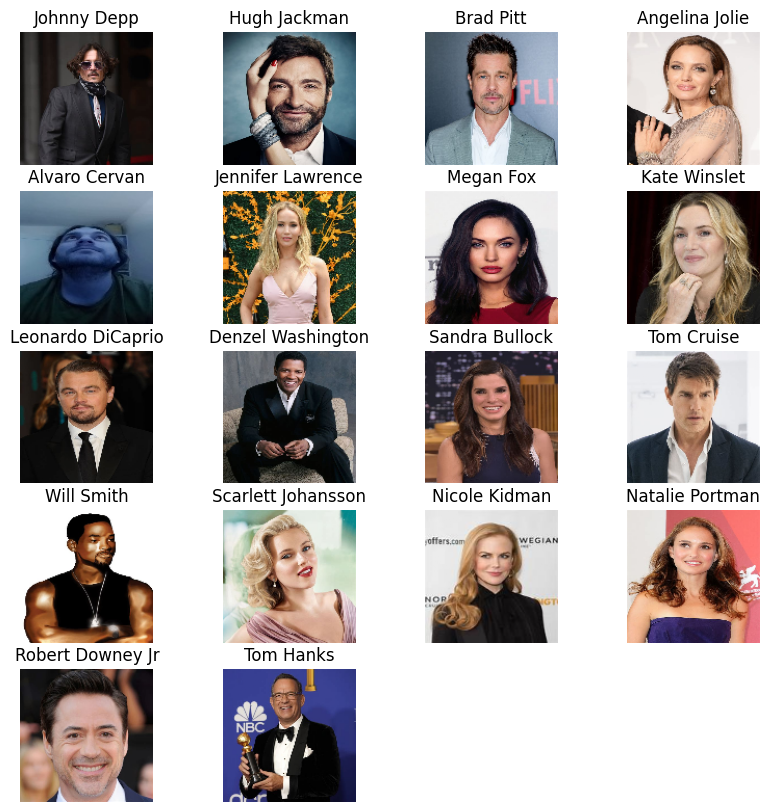

In [4]:
# print the first picture of each class with its label in a 5x4 grid
plt.figure(figsize=(10, 10))
for i in range(len(classes)):
	plt.subplot(5, 4, i + 1)
	plt.imshow(data[labels == i][0])
	plt.title(classes[i])
	plt.axis("off")
plt.show()

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Encode labels to categorical
num_classes = len(classes)
y_cat = to_categorical(labels, num_classes=num_classes)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# === Load VGG16 base model ===
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
vgg_base.trainable = False  # Freeze convolutional layers

# === Add classification head ===
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg_base.input, outputs=output)

# === Compile model ===
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Train model ===
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=32)

# === Evaluate model ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

# === Save model ===
model.save("/content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_face_classifier.h5")


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.0578 - loss: 3.1153 - val_accuracy: 0.1977 - val_loss: 2.7460
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.1868 - loss: 2.8370 - val_accuracy: 0.2114 - val_loss: 2.6188
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2170 - loss: 2.6864 - val_accuracy: 0.2386 - val_loss: 2.5298
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2527 - loss: 2.5856 - val_accuracy: 0.2727 - val_loss: 2.4558
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2605 - loss: 2.4882 - val_accuracy: 0.2864 - val_loss: 2.3967
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2587 - loss: 2.4585 - val_accuracy: 0.2977 - val_loss: 2.3443
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3006 - loss: 2.3238 - val_accuracy: 0.3136 - val_loss: 2.2996
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2933 - loss: 2.3551 - val_accuracy: 0.3250 -


✅ Test Accuracy: 45.00%


In [6]:
# use TensorFlow's Dataset API for efficient data loading
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Cache and prefetch the training dataset for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)


In [7]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Enable GPU and Mixed Precision ---
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# --- Create models folder if needed ---
os.makedirs("models", exist_ok=True)

# --- Load VGG16 base model ---
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = True

# --- Freeze only first few layers ---
for layer in base_model.layers[:10]:
    layer.trainable = False

# --- Build model ---
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(len(classes), activation='softmax', dtype='float32')  # Final output layer
])

# --- Compile model ---
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# --- Train the model ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - accuracy: 0.1930 - loss: 3.3850 - val_accuracy: 0.2455 - val_loss: 3.7337 - learning_rate: 1.0000e-04
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3143 - loss: 2.3992 - val_accuracy: 0.3477 - val_loss: 2.4306 - learning_rate: 1.0000e-04
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3935 - loss: 1.9590 - val_accuracy: 0.3455 - val_loss: 1.8282 - learning_rate: 1.0000e-04
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4945 - loss: 1.5800 - val_accuracy: 0.4932 - val_loss: 1.5078 - learning_rate: 1.0000e-04
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5621 - loss: 1.3183 - val_accuracy: 0.6000 - val_loss: 1.2277 - learning_rate: 1.0000e-04
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7013 - loss: 0.9195 - val_accuracy: 0.5205 - val_loss: 1.4755 - learning_rate: 1.0000e-04
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.756

In [8]:
# --- Save model in Keras format ---
model.save('/content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_face_recognition.keras')
